##Final Project Code

In [23]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.io import loadmat
import sklearn as skl
import pandas as pd
from sklearn.preprocessing import scale
from sklearn import cross_validation

C:\tools\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
#Load the data
data = np.loadtxt("breast-cancer-wisconsin.data.csv", delimiter=",")

#change 2 to 0 and 4 to 1
for i in range(len(data)):
    if data[i,10] == 2:
        data[i,10] = 0
    elif data[i,10] == 4:
        data[i,10] = 1
        
X = data[:,1:10]
Y = data[:,10]

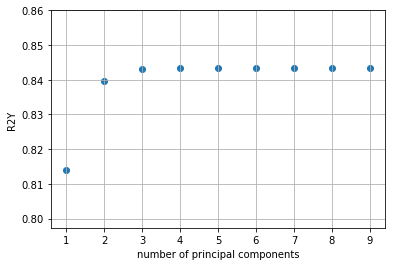

[ 0.81397888  0.83974134  0.84295668  0.84325165  0.84329905  0.84332356
  0.84332412  0.84332413  0.84332413]


In [26]:
#Perform PLS-DA
n = 10
R2Y = np.zeros(n-1)
for i in range(1,n):
    PLS = PLSRegression(n_components = i, max_iter = 1000)
    #now we can call functions on PLS such as "PLS.fit"

    xScores, yScores = PLS.fit_transform(scale(X), scale(Y)) # xSc is not the same as PLS.x_scores_

    R2Y[i-1] = PLS.score(scale(X), scale(Y))

    #Y_predict = PLS.predict(X)
    #R2Y[i-1] = 1 - (np.sum(Y_predict - Y48)**2) / np.sum(Y48)**2

plt.figure()
plt.scatter(np.arange(1,n), R2Y)
plt.xlabel("number of principal components")
plt.ylabel("R2Y")
plt.grid()
plt.show()
print(R2Y)

In [55]:
#Choose 2 components
PLS = PLSRegression(n_components = 2, max_iter = 1000)
xScores1, yScores = PLS.fit_transform(scale(X), scale(Y))
xloadings = PLS.x_loadings_
yloadings = PLS.y_loadings_

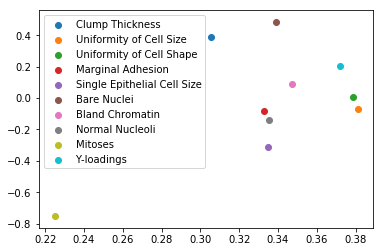

In [56]:
#Overlay Loadings
labels = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses']
for i in range(len(xloadings)):
    plt.scatter(xloadings[i,0], xloadings[i,1], label = labels[i] )

plt.scatter(yloadings[:,0], yloadings[:,1], label = 'Y-loadings')
plt.legend(loc = 2)
plt.show()

In [57]:
#Predict Y
Y_predicted = PLS.predict(X)

In [58]:
print(Y_predicted)

[[  2.19327425]
 [  6.16736389]
 [  2.06658081]
 [  5.69454446]
 [  2.17152447]
 [  9.88736357]
 [  3.85465923]
 [  1.72782521]
 [  1.18538319]
 [  1.98535425]
 [  1.33730989]
 [  1.46156567]
 [  3.87491381]
 [  1.93988737]
 [  7.90768523]
 [  4.4648639 ]
 [  1.86179795]
 [  1.99315811]
 [  7.85850859]
 [  2.39339039]
 [  6.86854366]
 [  7.71848897]
 [  1.66168181]
 [  1.3928097 ]
 [  5.00861855]
 [  1.7297383 ]
 [  2.06191409]
 [  1.46156567]
 [  1.39988812]
 [  1.606182  ]
 [  1.59292584]
 [  7.11106305]
 [  1.68210902]
 [  1.79658118]
 [  1.46156567]
 [  7.84416902]
 [  2.98688755]
 [  6.91988325]
 [  5.33455442]
 [  5.20534035]
 [  8.26183518]
 [  4.24056759]
 [  7.70107727]
 [  1.22524395]
 [  6.7604854 ]
 [  1.26144953]
 [  2.17152447]
 [  7.06503531]
 [  4.7031548 ]
 [  4.10627566]
 [  6.37322939]
 [  6.72363937]
 [  7.44680489]
 [  6.38286132]
 [  7.36404843]
 [  3.95040413]
 [  5.53319839]
 [  4.65300384]
 [  4.99442677]
 [  1.53498837]
 [  7.88389286]
 [  4.3063701 ]
 [  1.26